# Single Shot Multibox Detector 

This is to go through each important step of SSD.

Firstly, initialize important variables


In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'

import numpy as np
import os
os.chdir('..')
caffe_root = '/media/data/home/ypashchenko/caffe_ssd/'
import sys
sys.path.insert(0, caffe_root + 'python')
import time

import caffe
from caffe.proto import caffe_pb2

caffe.set_device(0)
caffe.set_mode_gpu()
# caffe.set_mode_cpu()

#specify task
test_task = 'test_people'
image_size = 300

Load the model. You only need to do this one time.

In [2]:
# We create a solver that fine-tunes from a previously trained network.
solver = caffe.SGDSolver(caffe_root + 'models/{}/SSD_{}x{}/solver.prototxt'.format(test_task, image_size, image_size))
solver.net.copy_from(caffe_root + 'models/VGGNet/VGG_ILSVRC_16_layers_fc_reduced.caffemodel')

# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': solver.net.blobs['data'].data.shape})
transformer.set_transpose('data', (2, 0, 1))
transformer.set_mean('data', np.array([104,117,123])) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB

net = solver.net

Load labelmap and define function which returns name accorfing to its label

In [3]:
from google.protobuf import text_format
from caffe.proto import caffe_pb2

# load PASCAL VOC labels
labelmap_file = 'data/{}/labelmap.prototxt'.format(test_task)
file = open(labelmap_file, 'r')
labelmap = caffe_pb2.LabelMap()

text_format.Merge(str(file.read()), labelmap)

# returns names according to its labels
def get_labelname(labelmap, labels):
    num_labels = len(labelmap.item)
    labelnames = []
    if type(labels) is not list:
        labels = [labels]
    for label in labels:
        found = False
        for i in xrange(0, num_labels):
            if label == labelmap.item[i].label:
                found = True
                labelnames.append(labelmap.item[i].display_name)
                break
        assert found == True
    return labelnames


#print info and first element
print 'labelmap consists of {} categories\n'.format(len(labelmap.item))
for i in range(len(labelmap.item)):
    print labelmap.item[i]

labelmap consists of 3 categories

name: "none_of_the_above"
label: 0
display_name: "background"

name: "47_69"
label: 1
display_name: "pets"

name: "143"
label: 2
display_name: "person"



Look at its blobs shapes

In [16]:
# each output is (batch size, feature dim, spatial dim)
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

[('data', (32, 3, 300, 300)),
 ('label', (1, 1, 85, 8)),
 ('data_data_0_split_0', (32, 3, 300, 300)),
 ('data_data_0_split_1', (32, 3, 300, 300)),
 ('data_data_0_split_2', (32, 3, 300, 300)),
 ('data_data_0_split_3', (32, 3, 300, 300)),
 ('data_data_0_split_4', (32, 3, 300, 300)),
 ('data_data_0_split_5', (32, 3, 300, 300)),
 ('data_data_0_split_6', (32, 3, 300, 300)),
 ('conv1_1', (32, 64, 300, 300)),
 ('conv1_2', (32, 64, 300, 300)),
 ('pool1', (32, 64, 150, 150)),
 ('conv2_1', (32, 128, 150, 150)),
 ('conv2_2', (32, 128, 150, 150)),
 ('pool2', (32, 128, 75, 75)),
 ('conv3_1', (32, 256, 75, 75)),
 ('conv3_2', (32, 256, 75, 75)),
 ('conv3_3', (32, 256, 75, 75)),
 ('pool3', (32, 256, 38, 38)),
 ('conv4_1', (32, 512, 38, 38)),
 ('conv4_2', (32, 512, 38, 38)),
 ('conv4_3', (32, 512, 38, 38)),
 ('conv4_3_relu4_3_0_split_0', (32, 512, 38, 38)),
 ('conv4_3_relu4_3_0_split_1', (32, 512, 38, 38)),
 ('pool4', (32, 512, 19, 19)),
 ('conv5_1', (32, 512, 19, 19)),
 ('conv5_2', (32, 512, 19, 19)),

Look at its weights and bises shapes

In [22]:
# just print the weight sizes (we'll omit the biases)
[(k, v[0].data.shape) for k, v in solver.net.params.items()]

[('conv1_1', (64, 3, 3, 3)),
 ('conv1_2', (64, 64, 3, 3)),
 ('conv2_1', (128, 64, 3, 3)),
 ('conv2_2', (128, 128, 3, 3)),
 ('conv3_1', (256, 128, 3, 3)),
 ('conv3_2', (256, 256, 3, 3)),
 ('conv3_3', (256, 256, 3, 3)),
 ('conv4_1', (512, 256, 3, 3)),
 ('conv4_2', (512, 512, 3, 3)),
 ('conv4_3', (512, 512, 3, 3)),
 ('conv5_1', (512, 512, 3, 3)),
 ('conv5_2', (512, 512, 3, 3)),
 ('conv5_3', (512, 512, 3, 3)),
 ('fc6', (1024, 512, 3, 3)),
 ('fc7', (1024, 1024, 1, 1)),
 ('conv6_1', (256, 1024, 1, 1)),
 ('conv6_2', (512, 256, 3, 3)),
 ('conv7_1', (128, 512, 1, 1)),
 ('conv7_2', (256, 128, 3, 3)),
 ('conv8_1', (128, 256, 1, 1)),
 ('conv8_2', (256, 128, 3, 3)),
 ('conv4_3_norm', (512,)),
 ('conv4_3_norm_mbox_loc', (12, 512, 3, 3)),
 ('conv4_3_norm_mbox_conf', (9, 512, 3, 3)),
 ('fc7_mbox_loc', (24, 1024, 3, 3)),
 ('fc7_mbox_conf', (18, 1024, 3, 3)),
 ('conv6_2_mbox_loc', (24, 512, 3, 3)),
 ('conv6_2_mbox_conf', (18, 512, 3, 3)),
 ('conv7_2_mbox_loc', (24, 256, 3, 3)),
 ('conv7_2_mbox_conf', (1

In [4]:
# Forward one step.
solver.step(1)

Now let's see the annotated datum after one forward-backward step.

/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


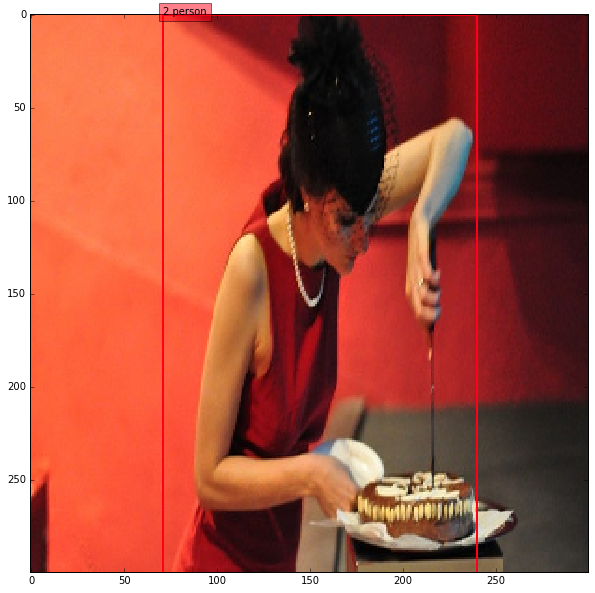

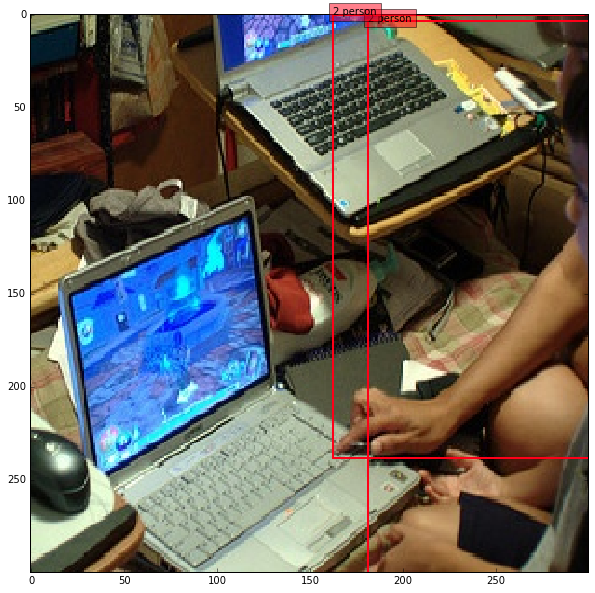

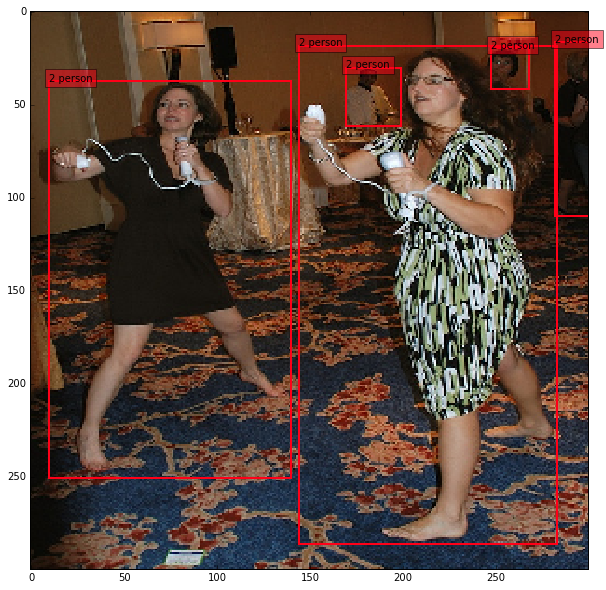

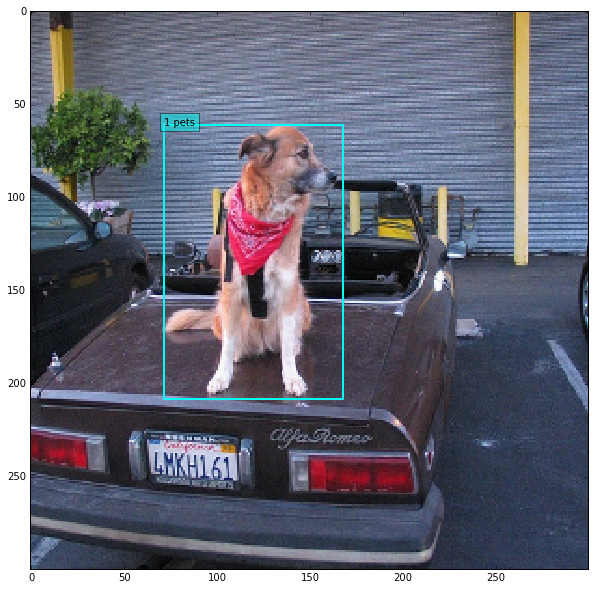

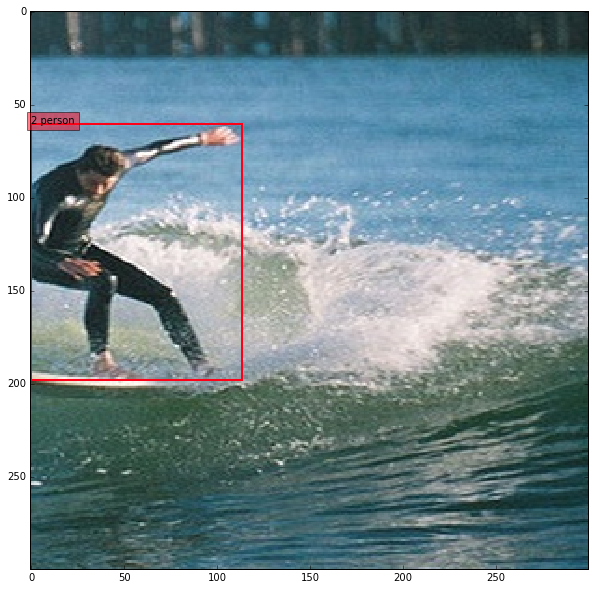

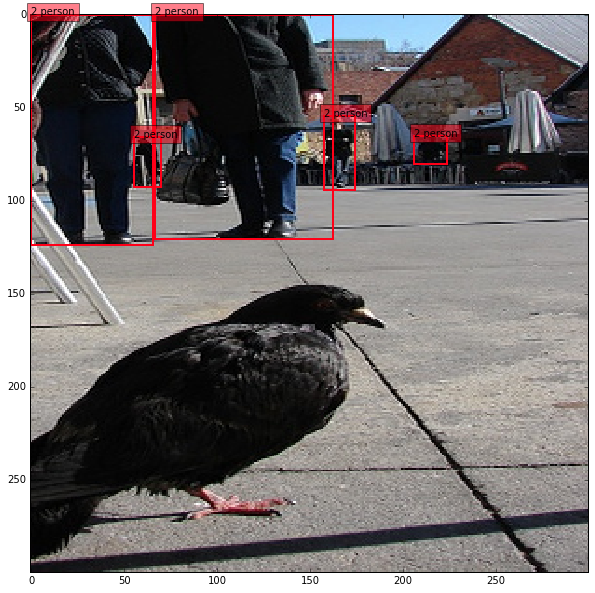

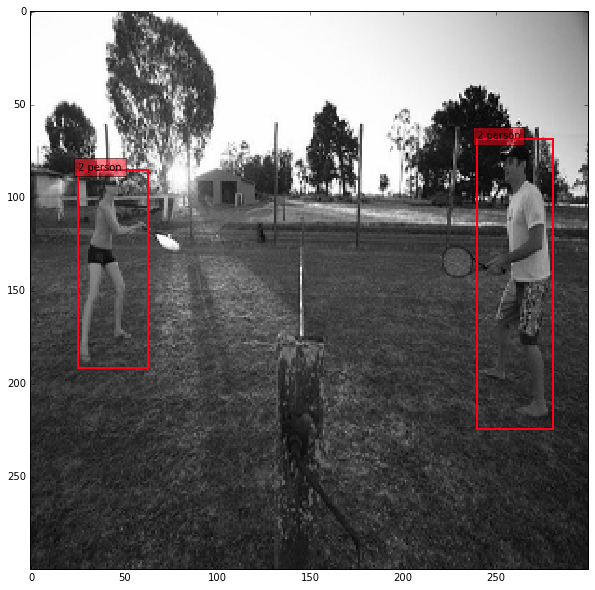

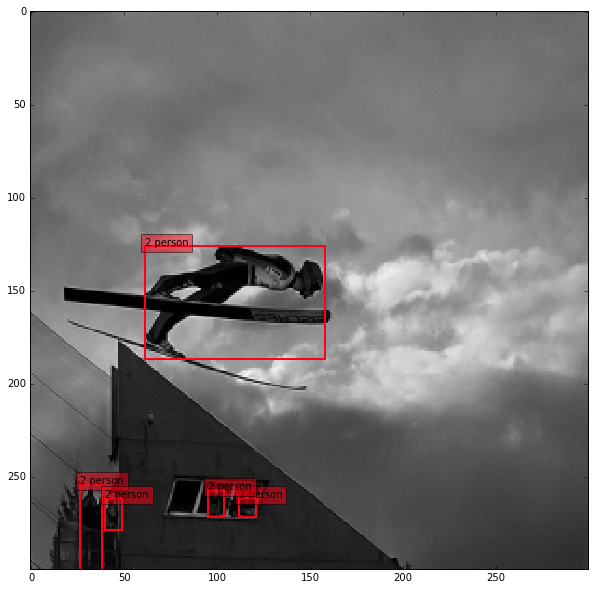

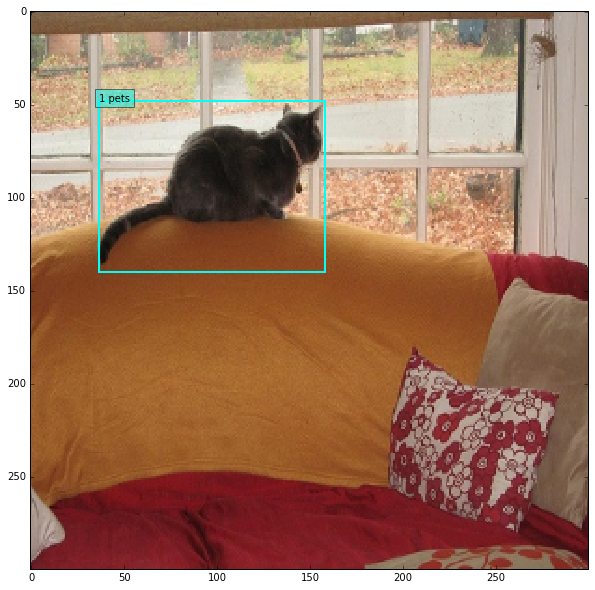

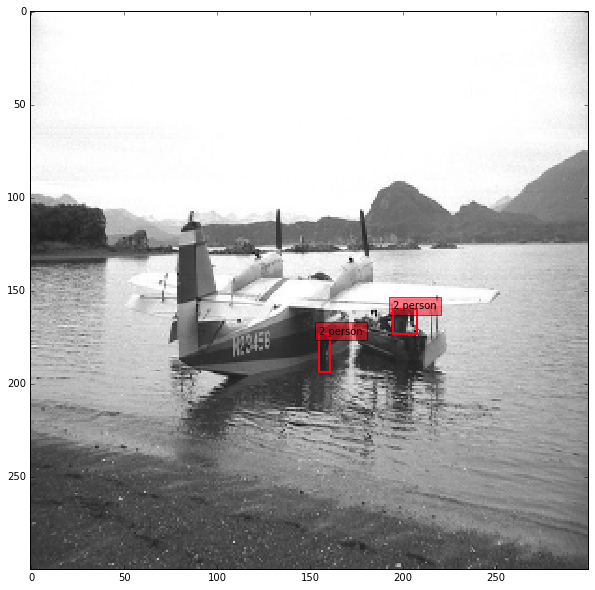

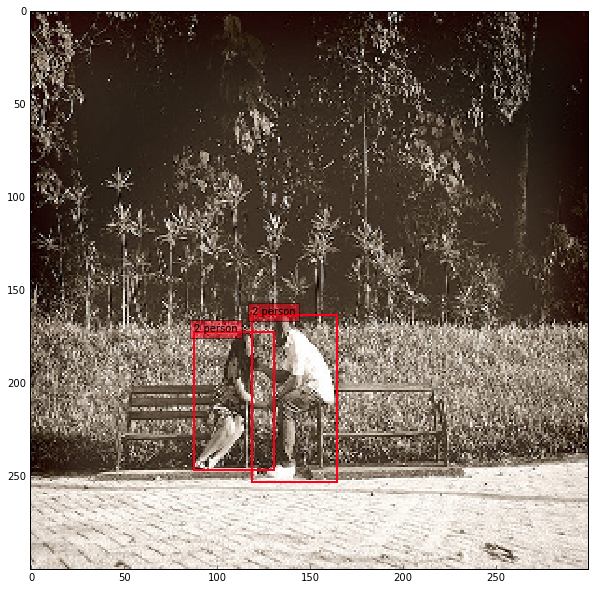

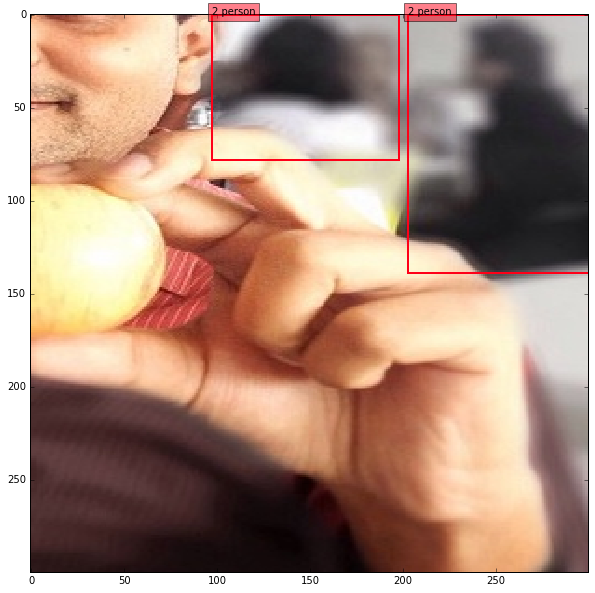

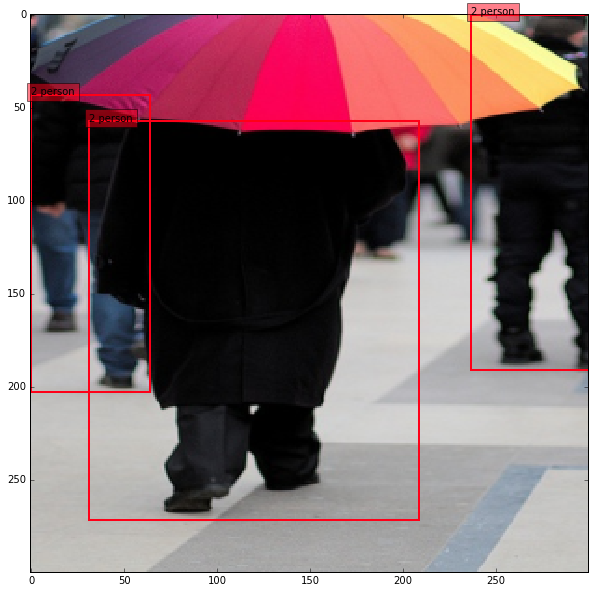

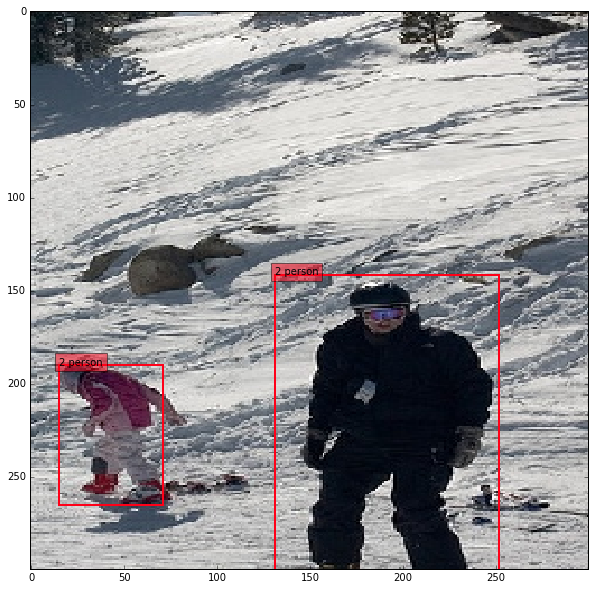

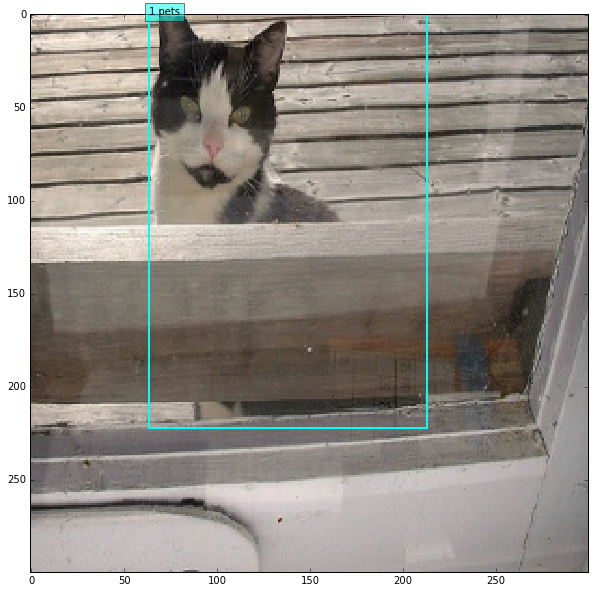

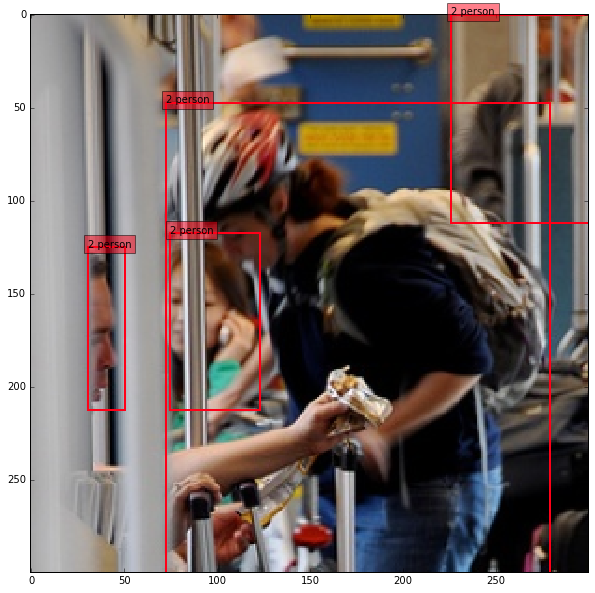

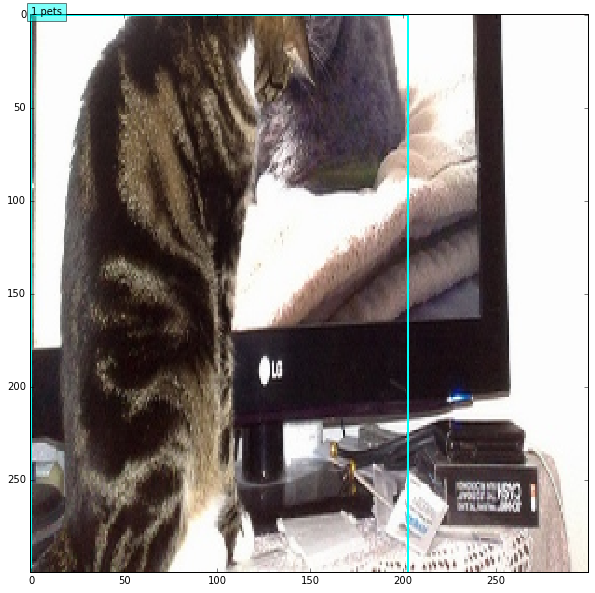

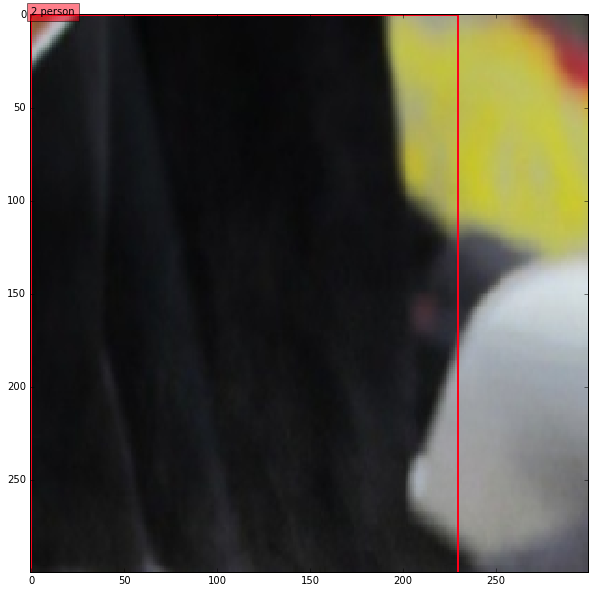

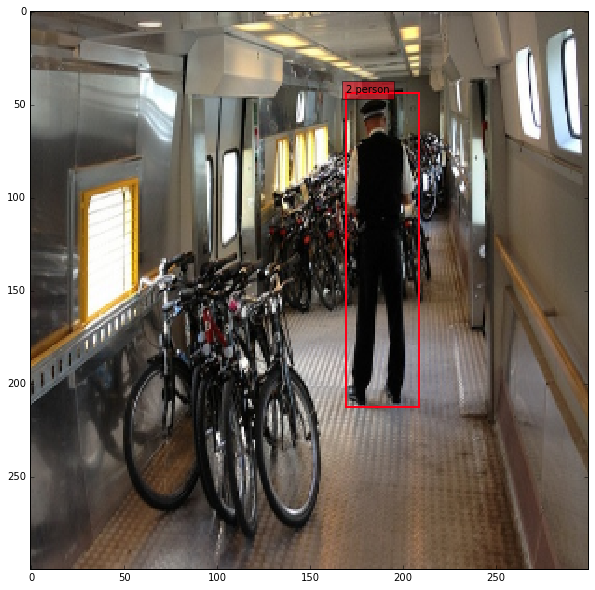

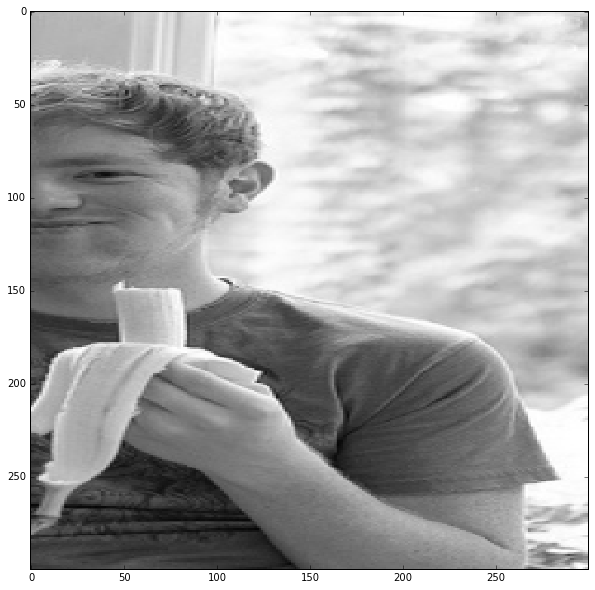

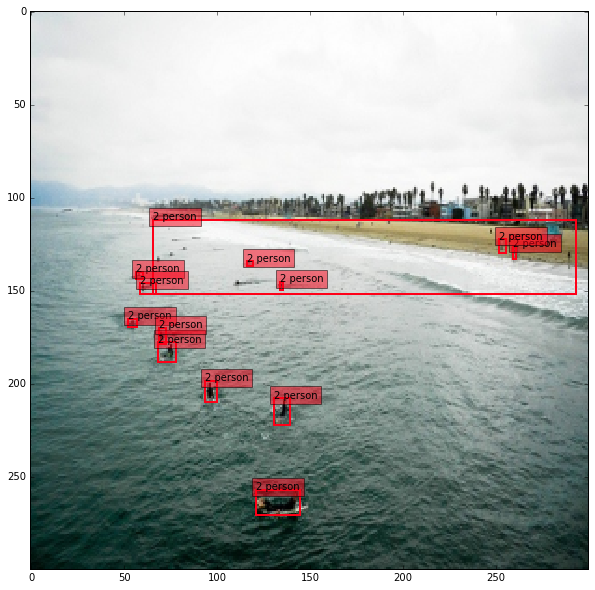

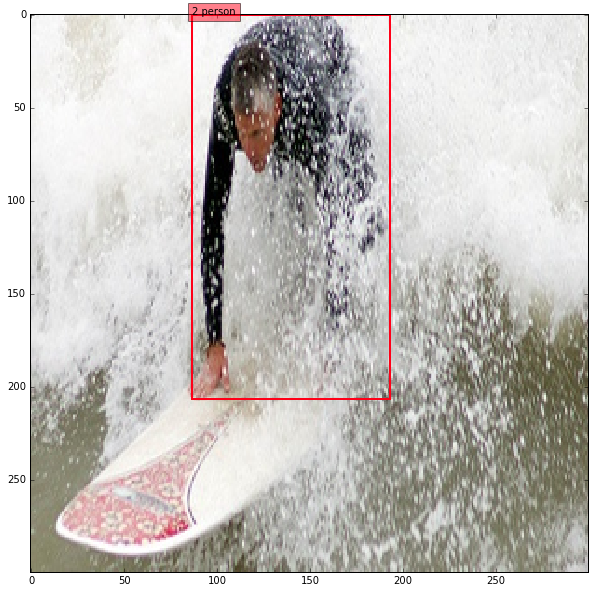

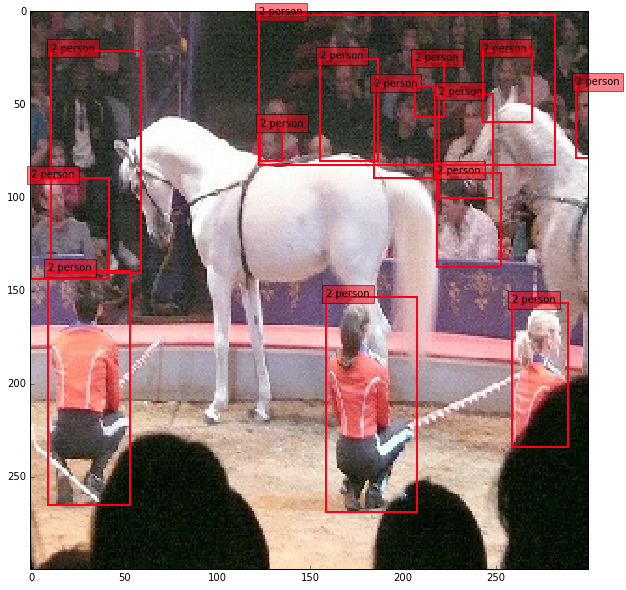

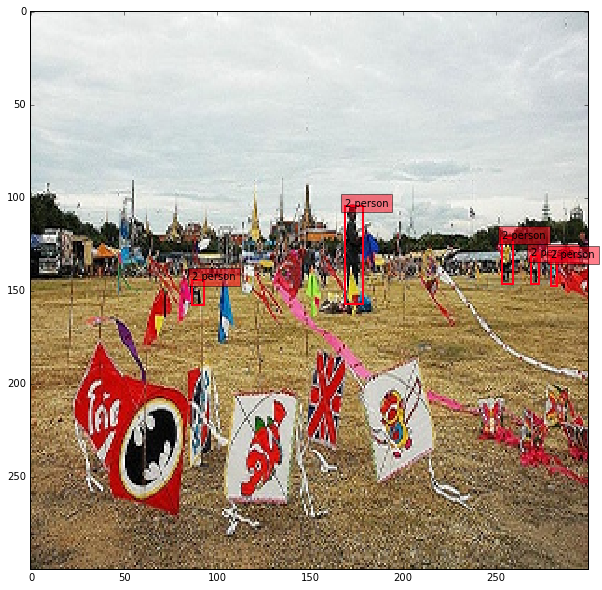

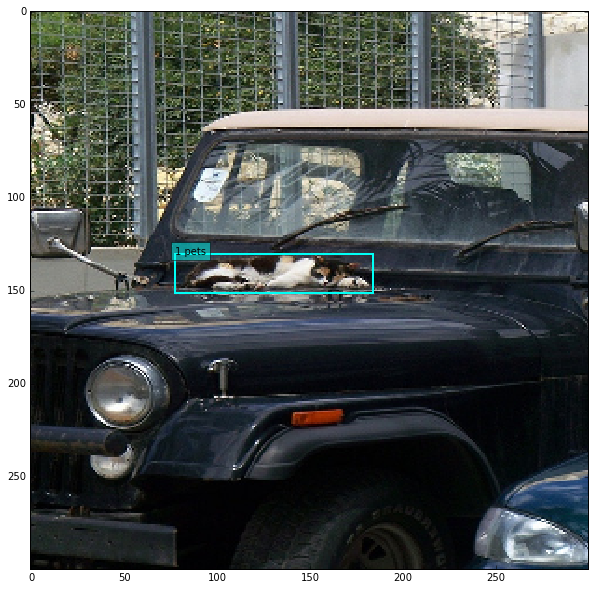

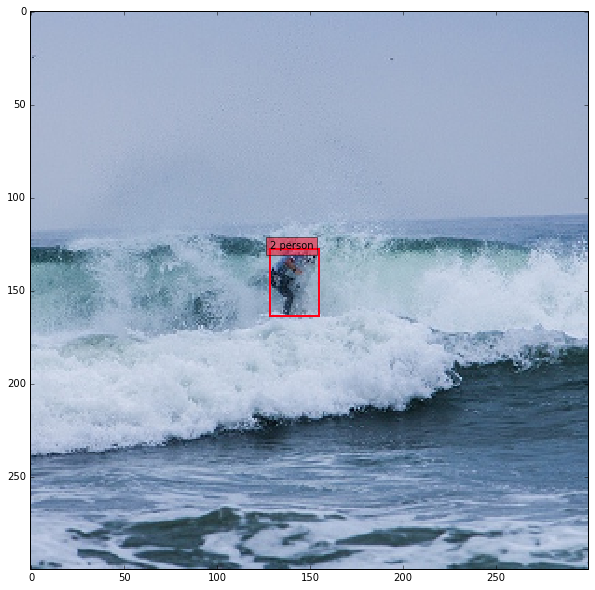

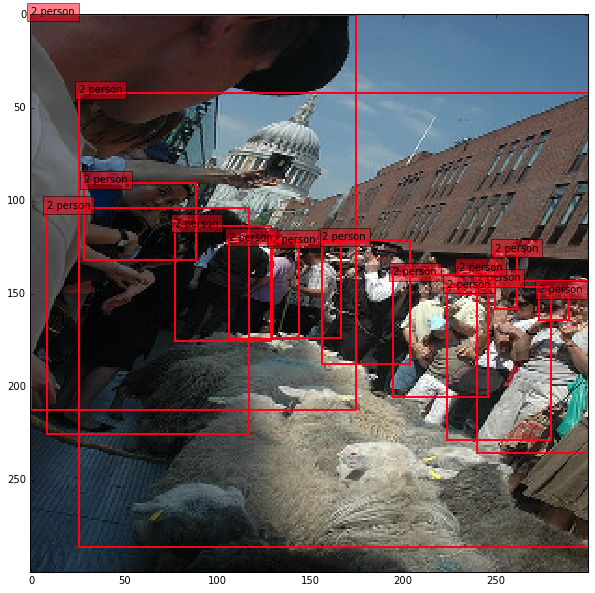

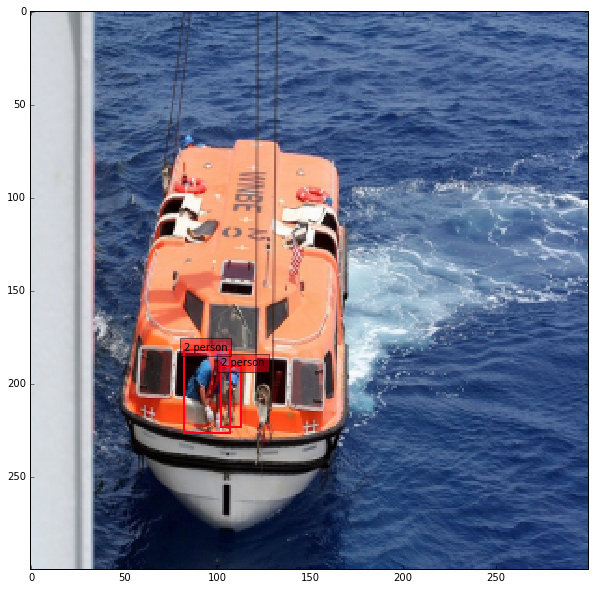

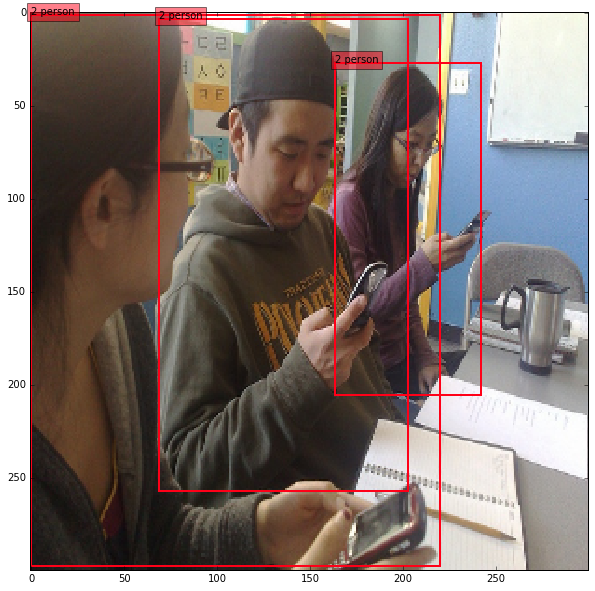

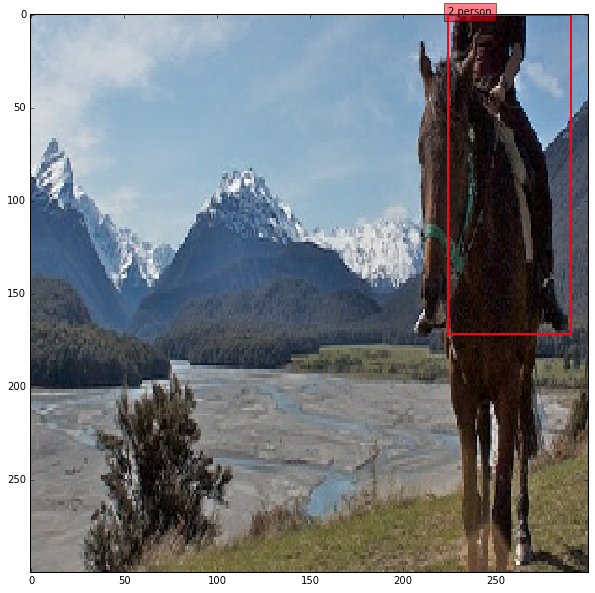

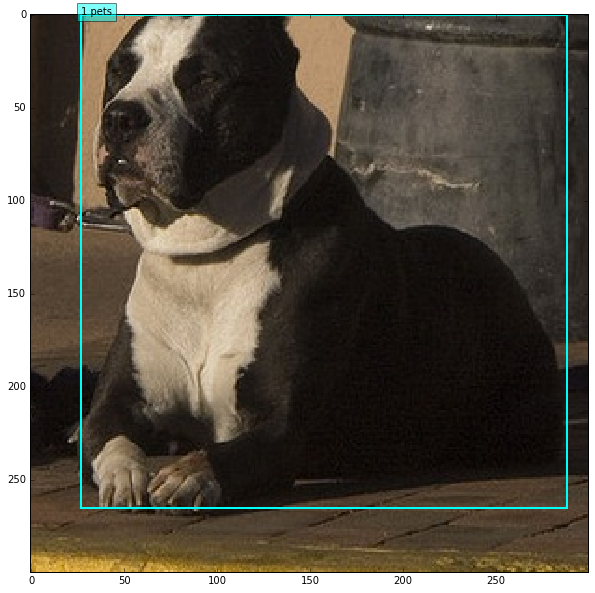

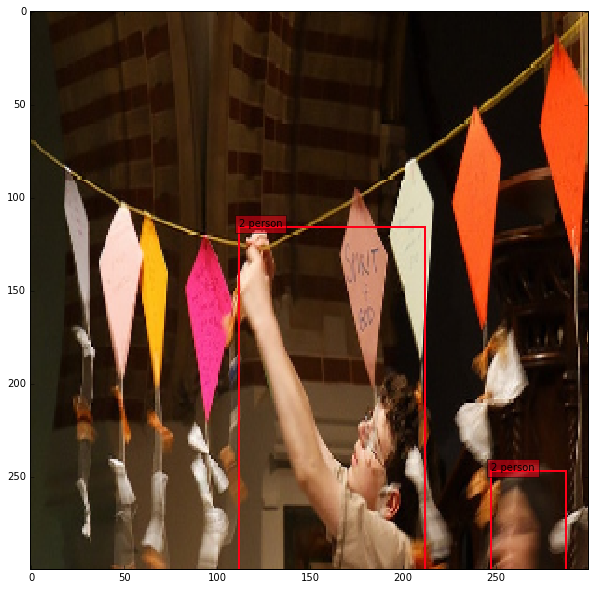

In [5]:
colors = plt.cm.hsv(np.linspace(0, 1, len(labelmap.item))).tolist()

img_blob = net.blobs['data'].data
num_imgs = img_blob.shape[0]
img_width = img_blob.shape[2]
img_height = img_blob.shape[3]
label_blob = net.blobs['label'].data[0,0,:,:]
num_labels = label_blob.shape[0]

for i in xrange(num_imgs):
    plt.figure()
    img = transformer.deprocess('data', img_blob[i])
    #plt.subplot(1, num_imgs, i + 1)
    plt.imshow(img)
    currentAxis = plt.gca()
    for j in xrange(num_labels):
        gt_bbox = label_blob[j, :]
        if gt_bbox[0] == i:
            #print '{} {} {} {}'.format(gt_bbox[3], gt_bbox[4], gt_bbox[5], gt_bbox[6])
            xmin = gt_bbox[3] * img_width
            ymin = gt_bbox[4] * img_height
            xmax = gt_bbox[5] * img_width
            ymax = gt_bbox[6] * img_height
            gt_label = int(gt_bbox[1])
            coords = (xmin, ymin), xmax - xmin + 1, ymax - ymin + 1
            color = colors[gt_label]
            currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
            #print gt_bbox[1]
            label = get_labelname(labelmap, gt_bbox[1])[0]
            currentAxis.text(xmin, ymin, str(gt_label) + " " + label, bbox={'facecolor':color, 'alpha':0.5})

In [9]:
# take an array of shape (n, height, width) or (n, height, width, channels)
# and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def vis_square(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data)

Let's visualize the conv1_1's filters to make sure we have loaded a good pretrained model. Otherwise, it should plot random noise squares.

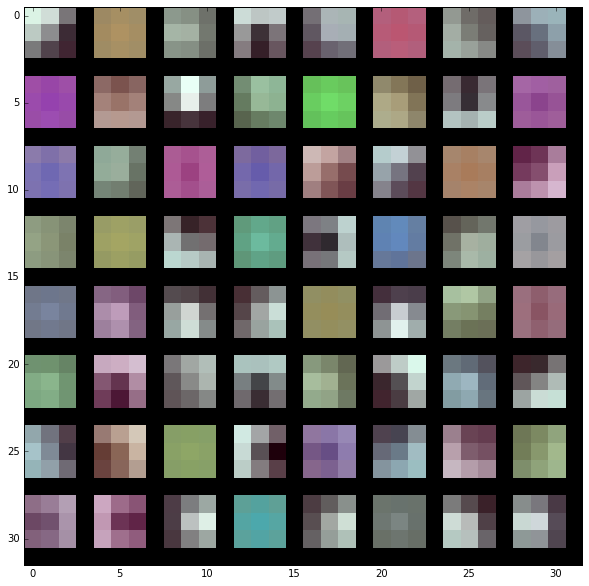

In [10]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1_1'][0].data
vis_square(filters.transpose(0, 2, 3, 1))

And let's visualize conv5_3 layer responses. You should see nicely pattern.

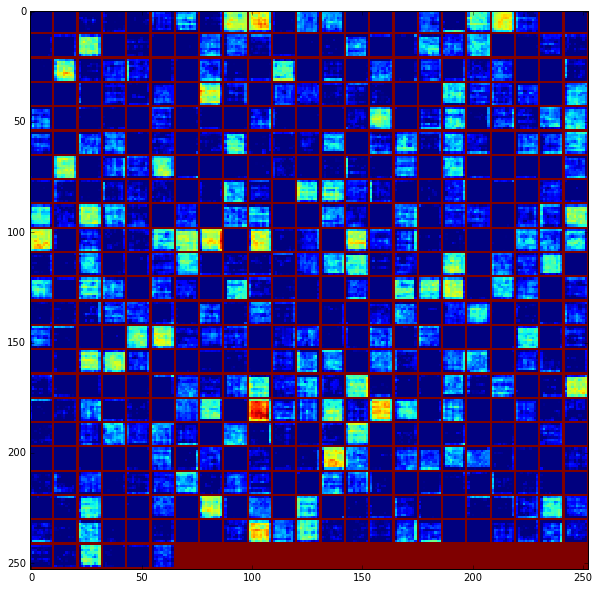

In [13]:
feat = net.blobs['conv6_2'].data[0, :]
vis_square(feat, padval=1)

Make sure that the PermuteLayer is doing the right thing.

In [14]:
fc7_mbox_loc = net.blobs['fc7_mbox_loc'].data
print fc7_mbox_loc[0,:,1,2]

fc7_mbox_loc_perm = net.blobs['fc7_mbox_loc_perm'].data
print fc7_mbox_loc_perm[0,1,2,:]

[ 0.45161003  0.16094936  0.28691974  0.28257433  0.4890416  -0.10152141
 -0.28979471 -0.18157026  0.2759037   0.29550818 -0.37731808  0.80932343
  0.31887108  0.02937393  0.87123507 -0.61492574  0.37020895 -0.23548938
 -0.2913599   1.0227555   0.00464145 -0.23256898  1.04186654 -0.54861605]
[ 0.45161003  0.16094936  0.28691974  0.28257433  0.4890416  -0.10152141
 -0.28979471 -0.18157026  0.2759037   0.29550818 -0.37731808  0.80932343
  0.31887108  0.02937393  0.87123507 -0.61492574  0.37020895 -0.23548938
 -0.2913599   1.0227555   0.00464145 -0.23256898  1.04186654 -0.54861605]


Make sure the PriorBoxLayer generates the correct priors.

(29232,)
29232


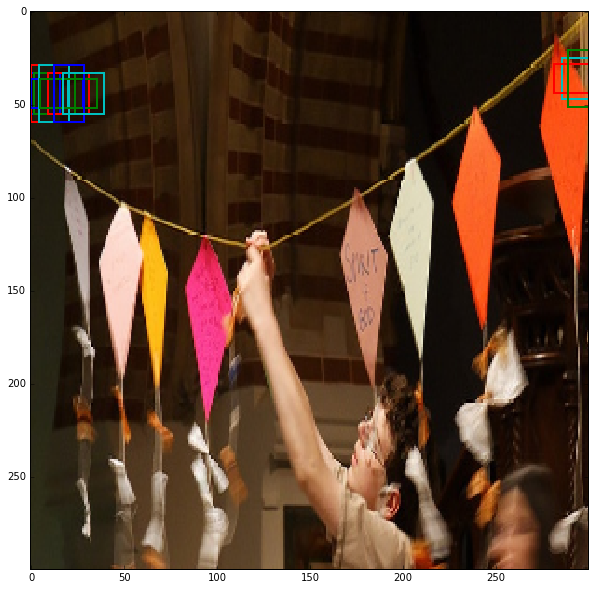

In [6]:
img_blob = net.blobs['data'].data
num_imgs = img_blob.shape[0]
img_width = img_blob.shape[2]
img_height = img_blob.shape[3]

priorbox = net.blobs['mbox_priorbox'].data[0,0,:]
num_priors = priorbox.shape[0]
print priorbox.shape
print num_priors

colors='rgbcmy'
for i in xrange(num_imgs):
    img = transformer.deprocess('data', img_blob[i])
    #plt.subplot(1, num_imgs, i + 1)
    plt.imshow(img)
    currentAxis = plt.gca()
    for j in xrange(567,580):
        prior_bbox = priorbox[j*4:(j+1)*4]
        xmin = prior_bbox[0] * img_width
        ymin = prior_bbox[1] * img_height
        xmax = prior_bbox[2] * img_width
        ymax = prior_bbox[3] * img_height
        coords = (xmin, ymin), xmax - xmin + 1, ymax - ymin + 1
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=colors[j%4], linewidth=2))